In [1]:
%pip install fastbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import fastbook
import torch
from fastai.vision.all import *
from fastbook import *
import numpy as np
import numpy.random as nprnd

fastbook.setup_book()



10.75
10.75


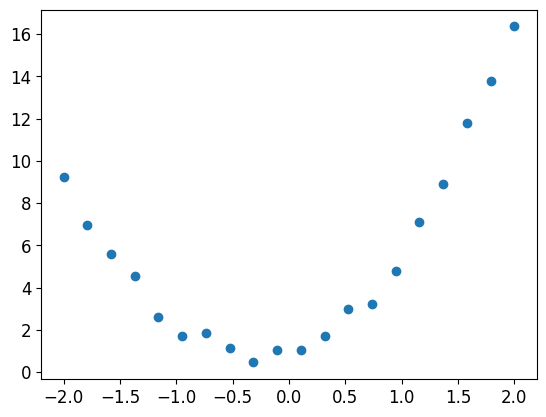

In [3]:
def quad(a,b,c,x): return a*x**2 + b*x + c
r = quad(3,2,1,1.5)
print(r)

def make_quad(a,b,c): return lambda x: a*x**2 + b*x + c
q = make_quad(3,2,1)
print(q(1.5))
np.random.seed(42)
def noise(x,scale):  return nprnd.normal(scale=scale,size=x.shape) 
def add_noise(x,mult,add): return x + mult*noise(x,add)

x = torch.linspace(-2,2,steps=20)[:,None]
y = add_noise(q(x),0.3,1.5)
plt.scatter(x,y)


In [35]:
from ipywidgets import interact
""" @interact(a=1.5,b=1.5,c=1.5) """
def plot_quad(a,b,c):
    f = make_quad(a,b,c)
    loss= mse(f(x),y)
    plot_function(f,title=f'Loss: {loss}')
    plt.scatter(x,y)

def mse(preds,acts): return ((preds-acts)**2).mean().sqrt()
def quad_mse(params):
    f= make_quad(*params)
    return mse(f(x),y)

def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y,0,)
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)
abc = torch.tensor((1.5,1.5,1.5),requires_grad=True)
loss = quad_mse(abc)
print(f'Loss: {loss}')
loss.backward()

abc.grad
with torch.no_grad():
    abc -= abc.grad * 0.01
    loss = quad_mse(abc)

print(f'Loss: {loss}')

for i in range(20):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad():
        abc -= abc.grad * 0.01
        abc.grad.zero_()
    """ print(f'Loss: {loss}') """
@interact(m1=1.5,b1=1.5,m2=1.5,b2=1.5)
def plot_rdouble_relu(m1,b1,m2,b2):
    plot_function(partial(double_relu,m1,b1,m2,b2))

Loss: 2.585228709805038
Loss: 2.544165625566391


interactive(children=(FloatSlider(value=1.5, description='m1', max=4.5, min=-1.5), FloatSlider(value=1.5, desc…

In [6]:
path = untar_data(URLs.PETS)
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=RandomResizedCrop(460, min_scale=0.75),
                 batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = pets.dataloaders(path/"images")
learn = Learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.model